## Homework 4

Use this notebook as a starter

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_parquet('s3://datasets/github/gastonstat/CreditScoring/CreditScoring.parquet', storage_options={
    'profile': 'local',
    'client_kwargs': {
        'endpoint_url': 'http://192.168.46.220:9000'
    }
})
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [142]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [143]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [144]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [145]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [146]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [147]:
numerical_cols = []
categorical_cols = []
for cname, dtype in df.dtypes.iteritems():
    if dtype == 'object':
        categorical_cols.append(cname)
    else:
        numerical_cols.append(cname)

In [148]:
numerical_cols

['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price',
 'default']

In [149]:
categorical_cols

['home', 'marital', 'records', 'job']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [158]:
df_train, df_test = train_test_split(df, test_size=0.4, shuffle=True, random_state=1)
df_val, df_test = train_test_split(df_test, test_size=0.5, shuffle=False, random_state=1)
y_train = df_train['default'].values
y_val = df_val['default'].values
y_test = df_test['default'].values

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [159]:
def calc_auc(y_true, y_score):
    roc = roc_auc_score(y_train, y_score)
    if roc < 0.5:
        roc = roc_auc_score(y_train, -y_score)
    return roc


df_train[numerical_cols].apply(lambda s: calc_auc(y_train, s)).sort_values(ascending=False)

default      1.000000
seniority    0.698955
income       0.671084
assets       0.637823
amount       0.584623
age          0.574130
time         0.554744
price        0.514446
expenses     0.507262
debt         0.502575
dtype: float64

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

Ans: seniority

<AxesSubplot:>

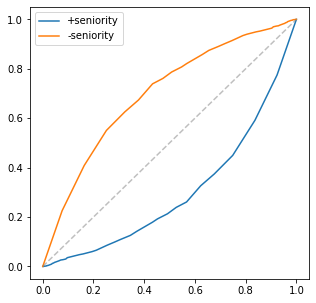

In [160]:
plt.figure(figsize=(5, 5))
fpr, tpr, _ = roc_curve(y_train, df_train.seniority)
sns.lineplot(x=fpr, y=tpr, label='+seniority')

fpr, tpr, _ = roc_curve(y_train, -df_train.seniority)
sns.lineplot(x=fpr, y=tpr, label='-seniority')

sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='gray', alpha=0.5)

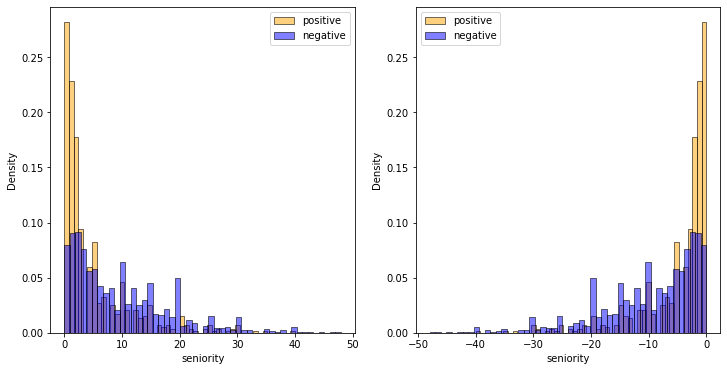

In [207]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(df_train.seniority[y_train == 1], color='orange', alpha=0.5, label='positive', bins=50, stat='density', ax=axs[0])
sns.histplot(df_train.seniority[y_train == 0], color='blue', alpha=0.5, label='negative', bins=50, stat='density', ax=axs[0])
axs[0].legend()

sns.histplot(-df_train.seniority[y_train == 1], color='orange', alpha=0.5, label='positive', bins=50, stat='density', ax=axs[1])
sns.histplot(-df_train.seniority[y_train == 0], color='blue', alpha=0.5, label='negative', bins=50, stat='density', ax=axs[1])
axs[1].legend()

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [208]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']
df_train = df_train[features]
df_val = df_val[features]
df_test = df_test[features]

In [265]:
def train(df, y, C=1.0, max_iter=1000):
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(df.to_dict(orient='records'))
    model = LogisticRegression(solver='liblinear', C=C, max_iter=max_iter)
    model.fit(X, y)
    return dv, model

def predict(df, dv, model):
    X = dv.transform(df.to_dict(orient='records'))
    y_hat = model.predict_proba(X)[:, 1]
    return y_hat


In [210]:
dv, model = train(df_train, y_train)

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

Ans: 0.812

In [211]:
y_hat = model.predict_proba(dv.transform(df_val.to_dict(orient='records')))[:, 1]

In [217]:
y_hat_hard = model.predict(dv.transform(df_val.to_dict(orient='records')))

In [220]:
round(roc_auc_score(y_val, y_hat), 3) # correct

0.778

In [221]:
round(roc_auc_score(y_val, y_hat_hard), 3) # wrong

0.664

showing why hard prediction is wrong when calculate auc
auc is calculating the posibility that drawing 2 samples a, b from different groups that the value of a is greater than b.

if we use hard prediction, we lose the precision dramatically.

<AxesSubplot:>

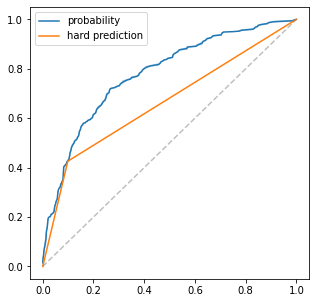

In [222]:
plt.figure(figsize=(5, 5))
fpr, tpr, _ = roc_curve(y_val, y_hat)
sns.lineplot(x=fpr, y=tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_hat_hard)
sns.lineplot(x=fpr, y=tpr, label='hard prediction')

sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='gray', alpha=0.5)

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [67]:
thresholds = np.linspace(0, 1, 101)
records = []
for t in thresholds:
    pp = y_hat >= t
    pn = ~pp
    ap = y_val == 1
    an = y_val == 0

    tp = (pp & ap).sum()
    tn = (pn & an).sum()
    fp = (pp & an).sum()
    fn = (pn & ap).sum()

    records.append((t, tp, tn, fp, fn))
df_scores = pd.DataFrame(records, columns=['threshold', 'tp', 'tn', 'fp', 'fn'])
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [227]:
df_scores['dist'] = np.abs(df_scores.precision - df_scores.recall)

In [242]:
df_scores[df_scores.dist == df_scores.dist.min()]

,threshold,tp,tn,fp,fn,precision,recall,F1,dist
38,0.38,155,518,110,108,0.584906,0.589354,0.587121,0.004448


Text(0.5, 0, 'threshold')

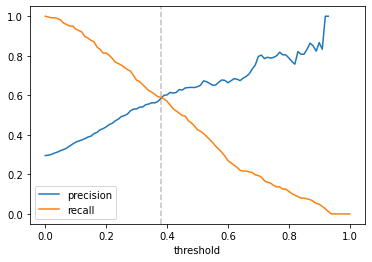

In [230]:
sns.lineplot(x=thresholds, y=df_scores.precision, label='precision')
sns.lineplot(x=thresholds, y=df_scores.recall, label='recall')
plt.ylabel('')
plt.axvline(0.38, color='grey', linestyle='--', alpha=0.5)
plt.xlabel('threshold')

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

Ans: 0.4

### Bonus Precision -recall curves

For aoc of PR curve, the closer it is to 1 thte better. The idea spot on the PR curve is (1, 1)

(0.0, 1.05)

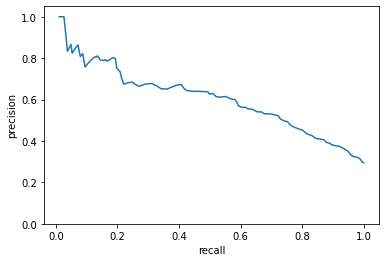

In [273]:
sns.lineplot(x='recall', y='precision', data=df_scores)
plt.ylim(0, 1.05)

In [278]:
df_scores = df_scores.dropna() # some precision is na
auc(df_scores.recall, df_scores.precision)

0.5955705176770236

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [243]:
df_scores['F1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

In [246]:
df_scores[df_scores['F1'] == df_scores['F1'].max()]

,threshold,tp,tn,fp,fn,precision,recall,F1,dist
28,0.28,190,454,174,73,0.521978,0.722433,0.606061,0.200455


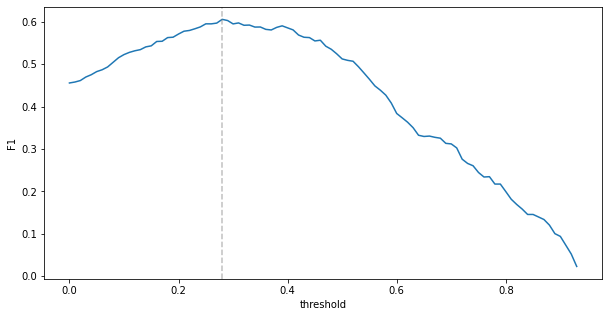

In [249]:
plt.figure(figsize=(10, 5))
sns.lineplot(x='threshold', y='F1', data=df_scores)
plt.axvline(0.28, color='grey', linestyle='--', alpha=0.5)

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

In [77]:
Ans: 0.28

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [250]:
df_full_train, df_test, y_full_train, y_test = train_test_split(df[features], df['default'].values, test_size=0.2)

In [268]:
scores = []
for train_idx, test_idx in KFold(n_splits=5, shuffle=True, random_state=1).split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    y_train = y_full_train[train_idx]

    df_val = df_full_train.iloc[test_idx]
    y_val = y_full_train[test_idx]
    dv, model = train(df_train, y_train)
    y_hat = predict(df_val, dv, model)
    scores.append(roc_auc_score(y_val, y_hat))

In [269]:
print(f'{np.mean(scores):.3f} +- {np.std(scores):.3f}')

0.809 +- 0.012


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

Ans: 0.012

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [270]:
Cs = [0.01, 0.1, 1, 10]
df_grid_scores = pd.DataFrame()
for C in Cs:
    scores = []
    for train_idx, test_idx in KFold(n_splits=5, shuffle=True, random_state=1).split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        y_train = y_full_train[train_idx]

        df_val = df_full_train.iloc[test_idx]
        y_val = y_full_train[test_idx]
        dv, model = train(df_train, y_train, C=C)

        y_hat = predict(df_val, dv, model)
        scores.append(roc_auc_score(y_val, y_hat))
    record = dict(
        C=C,
        mean=round(np.mean(scores), 3),
        std=round(np.std(scores), 3)
    )
    df_grid_scores = pd.concat([df_grid_scores, pd.DataFrame([record])], ignore_index=True)
    

In [271]:
df_grid_scores.sort_values(by='mean')

,C,mean,std
0,0.01,0.803,0.011
1,0.10,0.809,0.012
2,1.00,0.809,0.012
3,10.00,0.809,0.013


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

Ans: 0.1